In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def driver(x_all, y_all, num_devices, updates_before_sync,
           func, stocgrad, step_size, max_sync=1000):
    '''
    x_all, y_all: Data
    num_devices : Number of parallel devices to use.
    '''
    
    def device_sgd(w0, x_dev, y_dev, updates_before_sync,
                   step_size, stocgrad):
        w = w0
        for step in range(updates_before_sync):
            w = w - step_size * stocgrad(w0, x_dev, y_dev)
        return w
    
    assert len(x_all) == len(y_all)
    assert x_all.ndim == 2
    assert y_all.ndim == 1
    # Divide data among $K$ (num_devices) nodes.
    assert num_devices <= len(x_all)
    indices = np.arange(len(x_all))
    np.random.shuffle(indices)
    sindices = np.array_split(indices, num_devices)
    all_dev_data = [(x_all[s], y_all[s]) for s in sindices]
    assert len(all_dev_data) == num_devices
    
    d = x_all.shape[1]
    w = np.random.uniform(size=d)
    loss_list = []
    for rnd in range(max_sync):
        loss = func(w, x_all, y_all)
        loss_list.append(loss)
        w_devs = []
        for dev_id in range(num_devices):
            x_dev, y_dev = all_dev_data[dev_id]
            w_d = device_sgd(w, x_dev, y_dev, updates_before_sync,
                             step_size, stocgrad)
            w_devs.append(w_d)
        w_devs=np.vstack(w_devs)
        w = np.mean(w_devs, axis=0)
        assert len(w) == d
    return w, loss_list

In [3]:
def least_squared(w, x, y):
    assert x.ndim == 2
    assert len(w) == x.shape[1]
    y_ = np.matmul(x, w)
    return np.mean((y- y_)**2)

def least_squared_stocgrad(w, x, y):
    i = np.random.choice(np.arange(len(x)))
    x_, y_ = x[[i]], y[i]
    # print("x, y, w", x_, y_, w)
    # Index with array to retain dimensions.
    f = np.matmul(w, x_.T)
    # print("tt", (np.matmul(x_, w) - y_)**2)
    # print("f, ", f)
    g = 2 * (f - y_) * x_
    # print("g, ", g)
    return g

# Experiment 1

Synthetic experiment:
1. Local SGD vs Full-sync SGD
   Convergence as a function of communication rounds for synthetic data.
1. Local SGD vs Full-sync SGD
   Convergence as a function of number of parallel updates rounds for synthetic data
   

In [4]:
# 1-d + bias
def gety(x_all, wtrue):
    y = np.matmul(x_all, wtrue)
    e = np.random.normal(size=len(x_all))
    return y + 3

In [5]:
num_dev = 10
step_size = 0.1
# --- 100 dimension
dim = 100
x_all = np.random.uniform(low=-1.0, high=1.0, size=[10000, dim])
wtrue = np.random.uniform(low=-1.0, high=1.0, size=[dim])
y_all = gety(x_all, wtrue)

updates_before_sync = 10
max_sync = 50
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local100, loss_local100 = wsgd, loss

# ----
updates_before_sync = 1
max_sync = 200
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_sync100, loss_sync100 = wsgd, loss

# --- 200 dimension
dim = 150
x_all = np.random.uniform(low=-1.0, high=1.0, size=[10000, dim])
wtrue = np.random.uniform(low=-1.0, high=1.0, size=[dim])
y_all = gety(x_all, wtrue)

updates_before_sync = 10
max_sync = 30
step_size = 0.01
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local200, loss_local200 = wsgd, loss

# ----
updates_before_sync = 1
max_sync = 300
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_sync200, loss_sync200 = wsgd, loss


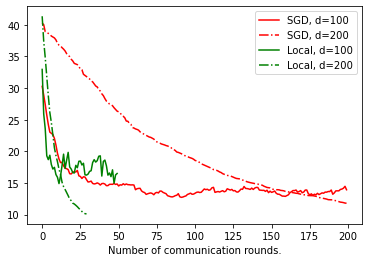

In [6]:
loss_sync100, loss_local100 = loss_sync100[:200], loss_local100[:200]
loss_sync200, loss_local200 = loss_sync200[:200], loss_local200[:200]
plt.plot(np.arange(len(loss_sync100)), loss_sync100, 'r', label='SGD, d=100')
plt.plot(np.arange(len(loss_sync200)), loss_sync200, 'r-.', label='SGD, d=200')
plt.plot(np.arange(len(loss_local100)), loss_local100, 'g', label='Local, d=100')
plt.plot(np.arange(len(loss_local200)), loss_local200, 'g-.', label='Local, d=200')
plt.xlabel("Number of communication rounds.")
plt.legend()
# plt.savefig('loss-vs-comm-synthetic.pdf')

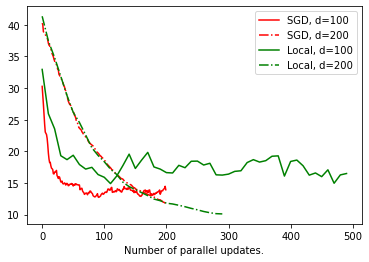

In [7]:
loss_sync100, loss_local100 = loss_sync100[:200], loss_local100[:200]
loss_sync200, loss_local200 = loss_sync200[:200], loss_local200[:200]
plt.plot(np.arange(len(loss_sync100)), loss_sync100, 'r', label='SGD, d=100')
plt.plot(np.arange(len(loss_sync200)), loss_sync200, 'r-.', label='SGD, d=200')
plt.plot(np.arange(len(loss_local100)) * 10, loss_local100, 'g', label='Local, d=100')
plt.plot(np.arange(len(loss_local200)) * 10, loss_local200, 'g-.', label='Local, d=200')
plt.xlabel("Number of parallel updates.")
plt.legend()
# plt.savefig('loss-vs-parallelupdates-synthetic.pdf')

# Experiment 2

Real world data:

1. Local SGD vs Full-sync SGD
   Convergence as a function of communication rounds for synthetic data.
1. Local SGD vs Full-sync SGD
   Convergence as a function of number of parallel updates rounds for synthetic data

In [8]:
df = pd.read_csv('insurance.csv')
df.sex = df.sex.replace(to_replace={'male': 1, 'female': 0})
df.smoker = df.smoker.replace(to_replace={'yes': 1, 'no': 0})
df.region = df.region.replace(to_replace={'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3})
features = df.columns[:-1]
label = df.columns[-1]
print("features, ", features)
print("labels, ", label)

features,  Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')
labels,  charges


In [9]:
X, y = df[features].values, df[label].values
# Add coorodinate for bias.
X = np.vstack([X.T, np.ones(len(X)).T]).T
print(X.shape, y.shape, type(X), type(y))
# Shuffle and split
indices = np.arange(len(X))
np.random.shuffle(indices)
X_real, y_real = X[indices], y[indices]
# train_indices = indices[:int(0.8 * len(indices))]
# test_indices = indices[int(0.8 * len(indices)):]
# x_train, y_train = X[train_indices], y[train_indices]
# x_test, y_test = X[test_indices], y[test_indices]
# print('train shape:', x_train.shape, y_train.shape)
# print('test shape:', x_test.shape, y_test.shape)

(1338, 7) (1338,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
# Fit to train data
num_dev = 10
step_size = 0.000005

updates_before_sync = 10
max_sync = 50
wsgd, loss = driver(X_real, y_real, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local_real, loss_local_real= wsgd, loss

# ----
updates_before_sync = 1
max_sync = 200
wsgd, loss = driver(X_real, y_real, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_sync_real, loss_sync_real= wsgd, loss

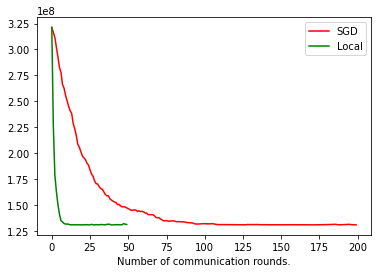

In [11]:
loss_sync_real, loss_local_real= loss_sync_real[:200], loss_local_real[:200]
plt.plot(np.arange(len(loss_sync_real)), loss_sync_real, 'r', label='SGD')
plt.plot(np.arange(len(loss_local_real)), loss_local_real, 'g', label='Local')
plt.xlabel("Number of communication rounds.")
plt.legend()
# plt.savefig('loss-vs-comm-insurace.pdf')

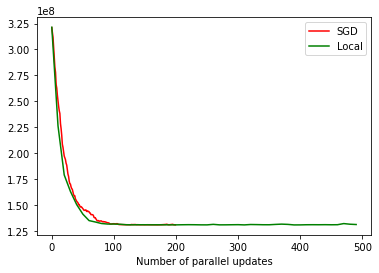

In [12]:
loss_sync_real, loss_local_real= loss_sync_real[:200], loss_local_real[:200]
plt.plot(np.arange(len(loss_sync_real)), loss_sync_real, 'r', label='SGD')
plt.plot(np.arange(len(loss_local_real)) * 10, loss_local_real, 'g', label='Local')
plt.xlabel("Number of parallel updates")
plt.legend()
# plt.savefig('loss-vs-parallelupdates-insurace.pdf')

# Experiment 3

Effect of synchronization duration.


In [23]:
num_dev = 10
step_size = 0.1
# --- 100 dimension
dim = 100
max_sync = 100

# Generate data
x_all = np.random.uniform(low=-1.0, high=1.0, size=[10000, dim])
wtrue = np.random.uniform(low=-1.0, high=1.0, size=[dim])
y_all = gety(x_all, wtrue)

# Perform exps
updates_before_sync = 5
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local5, loss_local5 = wsgd, loss

# Perform exps
updates_before_sync = 10
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local10, loss_local10 = wsgd, loss

# ----
updates_before_sync = 20
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local20, loss_local20 = wsgd, loss

# ----
updates_before_sync = 30
max_sync = 100
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local30, loss_local30 = wsgd, loss

# ----
updates_before_sync = 50
max_sync = 100
wsgd, loss = driver(x_all, y_all, num_devices=num_dev,
                    updates_before_sync=updates_before_sync,
                    func=least_squared, stocgrad=least_squared_stocgrad,
                    step_size=step_size, max_sync=max_sync)
w_local50, loss_local50 = wsgd, loss

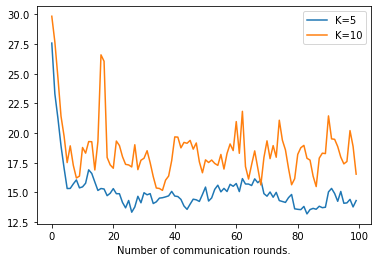

In [38]:
loss_local10 = loss_local10[:200]
loss_local20 = loss_local20[:200]
loss_local30 = loss_local30[:200]
loss_local50 = loss_local50[:200]

plt.plot(np.arange(len(loss_local5)), loss_local5, label='K=5')
plt.plot(np.arange(len(loss_local10)), loss_local10, label='K=10')
plt.xlabel("Number of communication rounds.")
plt.legend()
plt.savefig('loss-vs-comm-synthetic-H-5-10.pdf')


# plt.plot(np.arange(len(loss_local20)), loss_local20, label='H=20')
# plt.plot(np.arange(len(loss_local30)), loss_local30, 'r', label='H=30')
# plt.plot(np.arange(len(loss_local50)), loss_local50, 'r', label='H=50')
# plt.savefig('loss-vs-comm-synthetic.pdf')


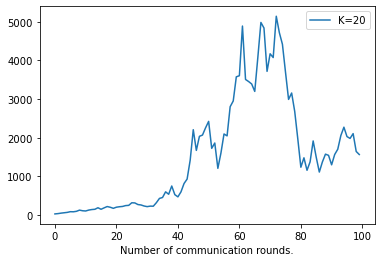

In [37]:
# plt.plot(np.arange(len(loss_local50)), loss_local50, label='H=50')
# plt.plot(np.arange(len(loss_local30)), loss_local30, label='H=30')
plt.plot(np.arange(len(loss_local20)), loss_local20, label='K=20')
plt.xlabel("Number of communication rounds.")
plt.legend()
plt.savefig('loss-vs-comm-synthetic-H-20.pdf')

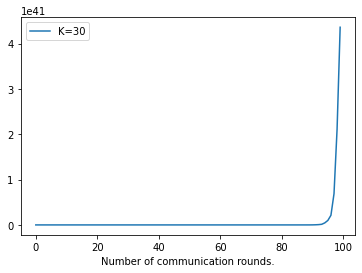

In [36]:
plt.plot(np.arange(len(loss_local30)), loss_local30, label='K=30')
plt.xlabel("Number of communication rounds.")
plt.legend()
plt.savefig('loss-vs-comm-synthetic-H-30.pdf')